# Basic model of perceptual inference
* Basic implementation of Jazayeri and Movshon, 2006 Nature Neuroscience

* The model  addresses the issue of how to combine the output of multiple sensory neurons in order to infer the most likely state of a stimulus that is driving the observed pattern of responses across the entire population of cells. This is a classic problem in sensory neuroscience (or really any area where you're combining noisy/ambiguous signals to make an optimal inference). The reason the problem is so interesting is that the output of a single neuron is almost useless for performing inference, even if the neuron has a highly stable output (e.g. an orientation tuning function) that can be robustly measured. This ambiguity arises for a few reasons. 

* First, there is variability (the unpredictable kind, i.e. 'noise') in the output of neurons - so a response of 50Hz might be observed to stimulus 1 on trial 1, but a response of 40Hz might be observed on trial 2, etc. Second, the tuning function of most sensory neurons is non-monotonic (e.g. Gaussian-ish), so that almost all repsonse states are consistent with at least two possible stimuli (even in the complete absence of noise). Thus, a single measurement from a single neuron cannot be used to reliably transmit much information at all about the stimulus that was most likely to have caused a response. 

* Instead, inference about sensory stimuli is thought to be based on the output of many sensory neurons that are tuned to different points across a given feature space. For example, if you have just two neurons, and they are tuned to different points in feature space, it immediately becomes much easier to discriminate which feature was presented based on the output PATTERN across the two neurons. The more neurons you add (generally speaking) the more accurate your inference will be in the presence of noise because each neuron will contribute a little bit to disambiguating the input feature. 

* Note also that this approach generates a full estimate of the likelihood function, not just a point estimate of the most likely stimulus. This is a key feature of the approach, because different tasks require the implementation of different decision rules. For example, you might choose the most likely stimulus in the context of a discrimination, but you would want to compare the likelihood to some adjustable criterion. Furthermore, if you want to integrate multiple sources of information, such as multisensory integration or combining sensory evidence with a prior, then you need to deal in likelihood functions, not point estimates. This is a really critical advantage of this model over other approaches that optimally (i.e. use all available information) to determine just a point estimate of the most likely stimulus. 

## Imports

In [1]:
import numpy as np
from numpy import pi as pi
import matplotlib.pyplot as plt
#import pandas as pd

# # seaborn - will make some basic use in tutorial today
# import seaborn as sns
# sns.set()

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## First some stimulus parameters - just going to simulate motion is different directions (i.e. a random dot stimulus ala Newsome). 

In [2]:
# motion coherence - will play with this later
mo_co = 1           

# this is the direction of the stimulus that we'll try to decode
s1 = pi             

## Then set up some params that define the stimulus space (i.e. not the stim that we're presenting per se, but the space of all possible stimuli that we might evaluate)

In [20]:
# number of possible directions
nDirs = 72   

# resolution sampling across direction space (radians)
dirStepSize = (2*pi)/nDirs             

# direction of each stimulus
sDir = np.linspace(0, (2*pi)-dirStepSize, nDirs)  

# xaxis of possible directions for plotting (Degrees)
xAxis = np.arange(0,360,360/nDirs)                

## Then some params to define our population of neurons
* Define the number of cells - we can play with this later
* Define the step size between the peaks of the tuning functions and then compute the actual peak of each tuning curve.
* Then define the 'concentration parameter' of each tuning function (the width of the circular Gaussian TF that we'll use)
* Want noise?

In [35]:
# number of neurons
N = 72          

# resolution sampling across direction space (radians)
stimStepSize = (2*pi)/nDirs  

# set up the direction preference of each neuron
nDir = np.linspace(0, (2*pi)-2*pi/N, N) 

# then some other factors - tuning function width and any noise
# we want to add to the responses
k = 7            # concentration param for tuning curve 
noise = .05        # noise (IID) of neural responses

## Then build the actual tuning function for each neuron
* Use a circular Gaussian (Von Mises function)

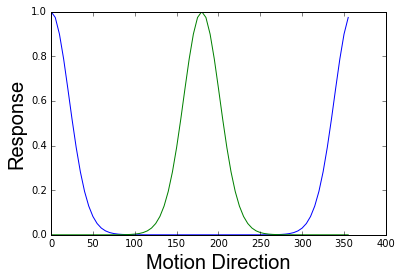

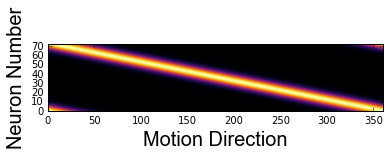

In [36]:
# loop over all possible sigs
fx = np.zeros((N,nDirs))

# loop over neurons...each of which is tuned to nDir[i]
for i in np.arange(N): 
    fx[i,:] = np.exp(k*(np.cos(sDir-nDir[i])-1))
                     
# set up a plotting axis in degrees (from radians)
xaxis = sDir*(180/pi)
plt.plot(xaxis, fx[0,])
plt.plot(xaxis, fx[36,])
plt.xlabel('Motion Direction', **fig_font)
plt.ylabel('Response', **fig_font)
plt.show()

# look at the full profile...
plt.imshow(fx, cmap='inferno', extent=[0, 360, 0, N])  # 'viridis', 'plasma', 'inferno', 'magma', etc
plt.xlabel('Motion Direction', **fig_font)
plt.ylabel('Neuron Number', **fig_font)
plt.show()

In [37]:
fx.shape

(72, 72)

## Figures 1-2 from J&M 2006 (and quick demo of LaTeX)
* Refer to equation 4 from the paper:


$$\log L(\theta) = \sum_{n=1}^{N}n_{i}{\cos(\theta - \theta_{i})}$$


* This is a rewriting of equ 3, where you had:

$$\log L(\theta) = \sum_{n=1}^{N}n_{i}{\log f_{i}(\theta)}$$
 
* So if: 

$$f(\theta) = e^{x}$$

* then: 

$$\log(e^{x}) == x$$
    
* which gives equation 4:

$$\log L(\theta) = \sum_{n=1}^{N}n_{i}{\cos(\theta - \theta_{i})}$$

### Given our bank of sensory neurons with tuning functions, generate a likelihood function to eval the most likely stim given pattern of observed responses
* First, we'll get the response vector to the stimulus of interest this R vector will correspond to the n1...ni vector in the paper
* Bonus - what is wrong with this version of the code??? 
    * re-run this cell several times with non-zero noise...what happens?
    * what is the problem and how to we fix it?

Noise:  0.05


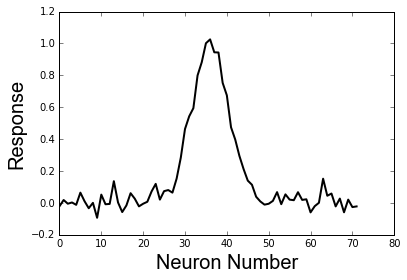

In [38]:
sInd = np.argmin(np.abs(s1-sDir))

# pull a column out of the matrix that defines our TFs. 
R = fx[:,sInd]

# add noise if desired
print('Noise: ', noise)
if noise:
    R += (np.random.randn(len(R)) * noise)   

# plot
plt.plot(R, 'k-', linewidth=2)
plt.xlabel('Neuron Number', **fig_font)
plt.ylabel('Response', **fig_font)
plt.show()

### What's wrong with the response vector that we have above?

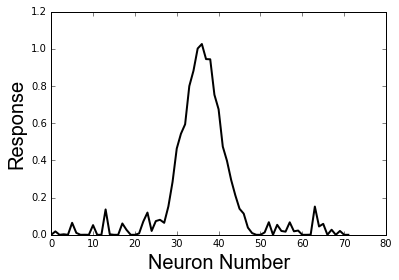

In [39]:
# set all negative responses to zero...
R[R<0]=0

# plot
plt.plot(R, 'k-', linewidth=2)
plt.xlabel('Neuron Number', **fig_font)
plt.ylabel('Response', **fig_font)
plt.show()

###  Then generate the weights to apply to R. Notice that this is exactly what the cos(theta-theta_pref_i) does...and its related to the magnitude of the response. By 'weight' here I just mean that the neurons that are most tuned to the stim will have the highest SNR response and should thus be 'trusted' the most in computing the log likelihood function. 

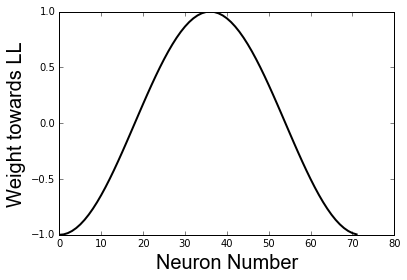

In [40]:
# take the part of the equation from above that computes the weight
w = np.cos(s1 - nDir) 

# plot
plt.plot(w, 'k-', linewidth=2)
plt.xlabel('Neuron Number', **fig_font)
plt.ylabel('Weight towards LL', **fig_font)
plt.show()

### Then compute the full LL for each possible stimulus in our space by looping over neuron, getting its response, and weighting it by its tuning funtion's offset to the stimulus. 

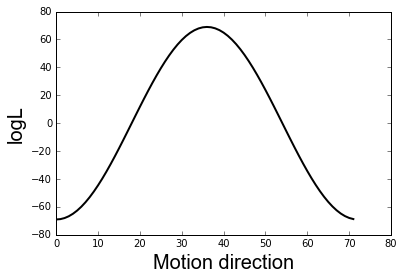

Estimated motion direction: 180.0  Degrees
Actual motion direction: 180.0  Degrees


In [41]:
# initialize an array of zeros...
logl = np.zeros(nDirs)

for s in np.arange(nDirs):
    logl[s] = k * np.sum(R*np.cos(sDir[s]-nDir))
                
# plot
plt.plot(logl, 'k-', linewidth=2)
plt.xlabel('Motion direction', **fig_font)
plt.ylabel('logL', **fig_font)
plt.show()

#MAP estimate of stim direction!
print('Estimated motion direction:', sDir[np.argmax(logl)]*180/pi, ' Degrees') 
print('Actual motion direction:', s1*180/pi, ' Degrees') 

## Now make Figure 4 from J&M 2006 (sort of) - how to do discrimination between two stims?
* first define 2 stims

In [42]:
s1 = pi
s2 = pi+pi/4

## we want to determine which stimulus is most likely given an observed

* Pattern of responses. One common scheme is the neuron/anti-neuron case developed by Newsome in which the likelihood of a stimulus is a function of activity in neurons tuned to the stimulus minus the activity of neurons to the opposite stimulus (the anti-neurons). This works fine, but it ignores the contribution of all neurons that aren't tuned to the stimulus (or to the anti-stimulus)...i.e. its not an optimal model. 

* An optimal approach is specified by the present model. What we want is to compute the ratio of the likelihood of each stimulus, so:

LRatio = L(s1)/L(s2)

* Going back to log space we would have:

LogLRatio = logL(s1) - logL(s2)

* Which is: 

LogLRatio = k*sum(R*cos(s1-theta_pref_i)) - k*sum(R*cos(s2-theta_pref_i))

* Or

LogLRatio = k*sum(R * [cos(s1-theta_pref_i) - cos(s2-theta_pref_i)])

* And what is cos(s1-theta_pref_i)? its the expected response of each neuron to s1, or the weights that we want to apply to the observed response profile to compute the likelihood of s1 (and same logic for s2). So the weighting funciton when compute the log likelihood ratio is the difference bewteen the weighting functions associated with each individual stimulus. 

In [43]:
sInd = np.argmin(np.abs(s1-sDir))

# pull a column out of the matrix that defines our TFs. 
R = fx[:,sInd]

R = R + np.random.randn(len(R))*noise

R[R<0] = 0 


### Generate the weights for s1 and s2 - this is determined by the expected response of a neuron to each stimulus

In [44]:
w1 = np.cos(s1-nDir)
w2 = np.cos(s2-nDir)

### Contribution of neurons to logL(s1) - this is the actual response of each neuron multiplied by the weight of each neuron (which is the TF, or the expected response of the neuron)

In [45]:
logL1=R*w1


### Then contribution of neurons to logL(s2)

In [46]:
logL2=R*w2

### Compute contribution of each neuron to LLR


In [48]:
logLR_cont = k * (R*(w1-w2))

### Compute the actual log likelihood ratio which is the sum of LLR for each neuron

In [50]:
logLR = k * sum(R*(w1-w2))

In [ ]:
# plot the data
nAxis = nDir*180/pi;
[tmp,nInd]=min(abs(s1*180/pi-nAxis)) # find the stimulus index

In [ ]:
clf        
subplot(2,2,1), hold on
title('recorded response')
plot(nAxis, R, 'o-', 'LineWidth', 2.5)
plot([nAxis(nInd),nAxis(nInd)], get(gca, 'YLim'),'k:')
set(gca, 'XLim', [0,360])
set(gca, 'FontSize', 16)
ylabel('response (hZ)')
xlabel('Direction')

subplot(2,2,2), hold on
title('weights for s1 and s2')
plot(nAxis, w1, 'LineWidth', 2.5)
plot(nAxis, w2, ':', 'LineWidth', 2.5)
plot([nAxis(nInd),nAxis(nInd)], get(gca, 'YLim'),'k:')
set(gca, 'XLim', [0,360])
set(gca, 'FontSize', 16)
ylabel('Weights')
xlabel('Direction')

subplot(2,2,3), hold on
title('Contribution of each Neuron to LL')
plot(nAxis, logL1, 'LineWidth', 2.5)
plot(nAxis, logL2, ':', 'LineWidth', 2.5)  
plot([nAxis(nInd),nAxis(nInd)], get(gca, 'YLim'),'k:')
set(gca, 'XLim', [0,360])
set(gca, 'FontSize', 16)
xlabel('Direction')